In [1]:
library(tidyverse)
library(Seurat)
library(patchwork)
library(writexl)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   0.3.4
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.2.1     ✔ stringr 1.4.1
✔ readr   2.1.2     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect




In [2]:
nhgc_d5 = qs::qread('_targets_MAST/objects/combined_nhgc_Day5.obob5v5__v__Day5.obobBL6d5')
nhgc_d14 = qs::qread('_targets_MAST/objects/combined_nhgc_Day14.obob14v14__v__Day14.obobBL6d14')
nhgc = bind_rows(nhgc_d5, nhgc_d14)

In [3]:
meta_other = qs::qread('../00_cellbender/_targets/objects/obj_cb_other_01') %>% `[[`
meta_neuron = qs::qread('../00_cellbender/_targets/objects/obj_cb_neuron_00') %>% `[[`

In [68]:
meta = meta_other %>% rownames_to_column %>% bind_rows(meta_neuron %>% rownames_to_column) %>% left_join(nhgc) %>% filter(!is.na(fgf1_grouping))

Joining with `by = join_by(rowname)`


In [69]:
meta %>% head

,rowname,orig.ident,nCount_RNA,nFeature_RNA,nCount_RNA_SCOP,nFeature_RNA_SCOP,Index.10x_SCOP,nCount_HTO_SCOP,nFeature_HTO_SCOP,Index.HTO_SCOP,⋯,class,integrated_snn_res.0.8,labels_lvl1,labels_chunk,labels_lvl1_mg,prediction.score.max,labels_lvl2,restored_grouping,bl6_grouping,fgf1_grouping
,<chr>,<chr>,<dbl>,<int>,<dbl>,<int>,<chr>,<dbl>,<int>,<chr>,⋯,<chr>,<fct>,<chr>,<chr>,<chr>,<dbl>,<chr>,<fct>,<chr>,<chr>
1,SI-TT-A11_AAACCCAGTATCGGTT,SI-TT-A11,1533,1175,4761,2296,SI-TT-A11,1150,12,D706,⋯,other,4,Tanycytes,g1,NA,NA,NA,none,none,none
2,SI-TT-A11_AAACGAAAGGTTCTTG,SI-TT-A11,1922,1253,7617,2701,SI-TT-A11,788,12,D706,⋯,other,13,OPC,g3,NA,NA,NA,none,none,none
3,SI-TT-A11_AAACGAACAAGGAGTC,SI-TT-A11,4800,2306,12026,3374,SI-TT-A11,1753,12,D706,⋯,other,2,Astrocytes,g2,NA,NA,NA,none,pos,none
4,SI-TT-A11_AAACGAACAGCCTTCT,SI-TT-A11,2787,1652,8725,2985,SI-TT-A11,1667,12,D706,⋯,other,2,Astrocytes,g2,NA,NA,NA,none,none,none
5,SI-TT-A11_AAACGCTAGTGCTAGG,SI-TT-A11,1257,946,3580,1882,SI-TT-A11,991,12,D706,⋯,other,8,Tanycytes,g1,NA,NA,NA,none,none,none
6,SI-TT-A11_AAAGGATTCAACCCGG,SI-TT-A11,1761,1248,5875,2654,SI-TT-A11,1304,12,D706,⋯,other,17,Tanycytes,g1,NA,NA,NA,none,none,none


In [70]:
meta %>% colnames

[1] "rowname"                            "orig.ident"                        
 [3] "nCount_RNA"                         "nFeature_RNA"                      
 [5] "nCount_RNA_SCOP"                    "nFeature_RNA_SCOP"                 
 [7] "Index.10x_SCOP"                     "nCount_HTO_SCOP"                   
 [9] "nFeature_HTO_SCOP"                  "Index.HTO_SCOP"                    
[11] "nCount_spliced_SCOP"                "nFeature_spliced_SCOP"             
[13] "nCount_unspliced_SCOP"              "nFeature_unspliced_SCOP"           
[15] "HTO_mcl_maxID_SCOP"                 "HTO_mcl_secondID_SCOP"             
[17] "HTO_mcl_margin_SCOP"                "HTO_mcl_classification_SCOP"       
[19] "HTO_mcl_classification.global_SCOP" "hash.mcl.ID_SCOP"                  
[21] "doublet_SCOP"                       "predicted_dub_std_SCOP"            
[23] "predicted_dub_cut_SCOP"             "barcode_SCOP"                      
[25] "Index.10x"                          "barcode"                           
[27] "strain"                             "treatment"                         
[29] "time"                               "collection_date"                   
[31] "isolation_date"                     "batch"                             
[33] "integrated_snn_res.0.5"             "seurat_clusters"                   
[35] "class"                              "integrated_snn_res.0.8"            
[37] "labels_lvl1"                        "labels_chunk"                      
[39] "labels_lvl1_mg"                     "prediction.score.max"              
[41] "labels_lvl2"                        "restored_grouping"                 
[43] "bl6_grouping"                       "fgf1_grouping"

In [71]:
beeswarm_results = meta %>%
mutate(polarity_fgf1 = fgf1_grouping,
       polarity_bl6 = bl6_grouping,
       labels = labels_lvl1)

In [72]:
# beeswarm_results = qs::qread('beeswarm_da_results_d5_MAST.qs')
# beeswarm_results %>% head

In [73]:
# beeswarm_results = qs::qread('beeswarm_da_results_d5_MAST.qs')

# Step 1: Summarizing the original data including class
original_summary <- beeswarm_results %>%
  filter(!is.na(class)) %>%
  group_by(class, labels, fgf1_grouping) %>%
  summarise(count = n(), .groups = 'drop')

# Step 2: Creating a summary for non-'none' categories
not_none_summary <- original_summary %>%
  filter(fgf1_grouping != 'none') %>%
  group_by(class, labels) %>%
  summarise(not_none_count = sum(count), .groups = 'drop')

# Step 2: Creating a summary for non-'none' categories
total_summary <- original_summary %>%
  group_by(class, labels) %>%
  summarise(total_count = sum(count), .groups = 'drop')

# Step 3: Joining the summaries
final_summary <- original_summary %>%
  left_join(not_none_summary, by = c("class", "labels")) %>%
  left_join(total_summary, by = c("class", "labels")) %>%
  mutate(not_none_count = replace_na(not_none_count, 0)) %>%
  arrange(desc(not_none_count), labels) %>%
  mutate(labels = factor(labels, levels = unique(labels)))

# Step 4: Calculate percentages
final_summary_percent <- final_summary %>%
  group_by(class, labels) %>%
  mutate(total_count = sum(count)) %>%
  ungroup() %>%
  mutate(percent = count / total_count) %>%
  mutate(fgf1_grouping = factor(fgf1_grouping, levels = c("pos", "none", "neg")))


In [74]:
saved_levels = final_summary_percent %>% pull(labels) %>% levels

In [75]:
saved_levels

[1] "Astrocytes"        "Htr3b"             "OPC"              
 [4] "Agrp"              "Tanycytes"         "Trh/Lef1"         
 [7] "Ghrh"              "Oligodendrocytes"  "Pomc/Glipr1"      
[10] "Tbx19/Pirt"        "Kiss1/Tac2"        "Ppp1r17/Tafa4"    
[13] "Sst/Unc13c"        "Ependymal_cells"   "Pou6f2/Prkcq/Whrn"
[16] "Sst/Pthlh"         "Th/Slc6a3"         "Nfix/Nfib"        
[19] "Irx5/Lmx1a"        "Arx/Nr5a2"         "Dlk1"             
[22] "Endothelial_cells" "Esr1"              "Fez1"             
[25] "Gpr50/Tac2"        "Hdc"               "Lepr15"           
[28] "Lepr67"            "Lepr89"            "Lpar1_oligo"      
[31] "Met/Pappa2"        "Met/Prlh"          "Microglia"        
[34] "Nfib_1"            "Nfib_2"            "Nfib_3"           
[37] "Nfix/Nfib/Hgf"     "Nfix/Nfib/Lhx6"    "Npsr1/Epha3"      
[40] "Pomc/Anxa2"        "Pomc/Ttr"          "Ppp1r17"          
[43] "Ppp1r17/Ltbp1"     "Reln/Lef1"         "Sim1"             
[46] "Slc17a6/Trhr"      "Sst/Nts"           "Th/Nfib"          
[49] "Tmem215/Dach2"     "Tmem215/Greb1"     "Trh/Cxcl12"

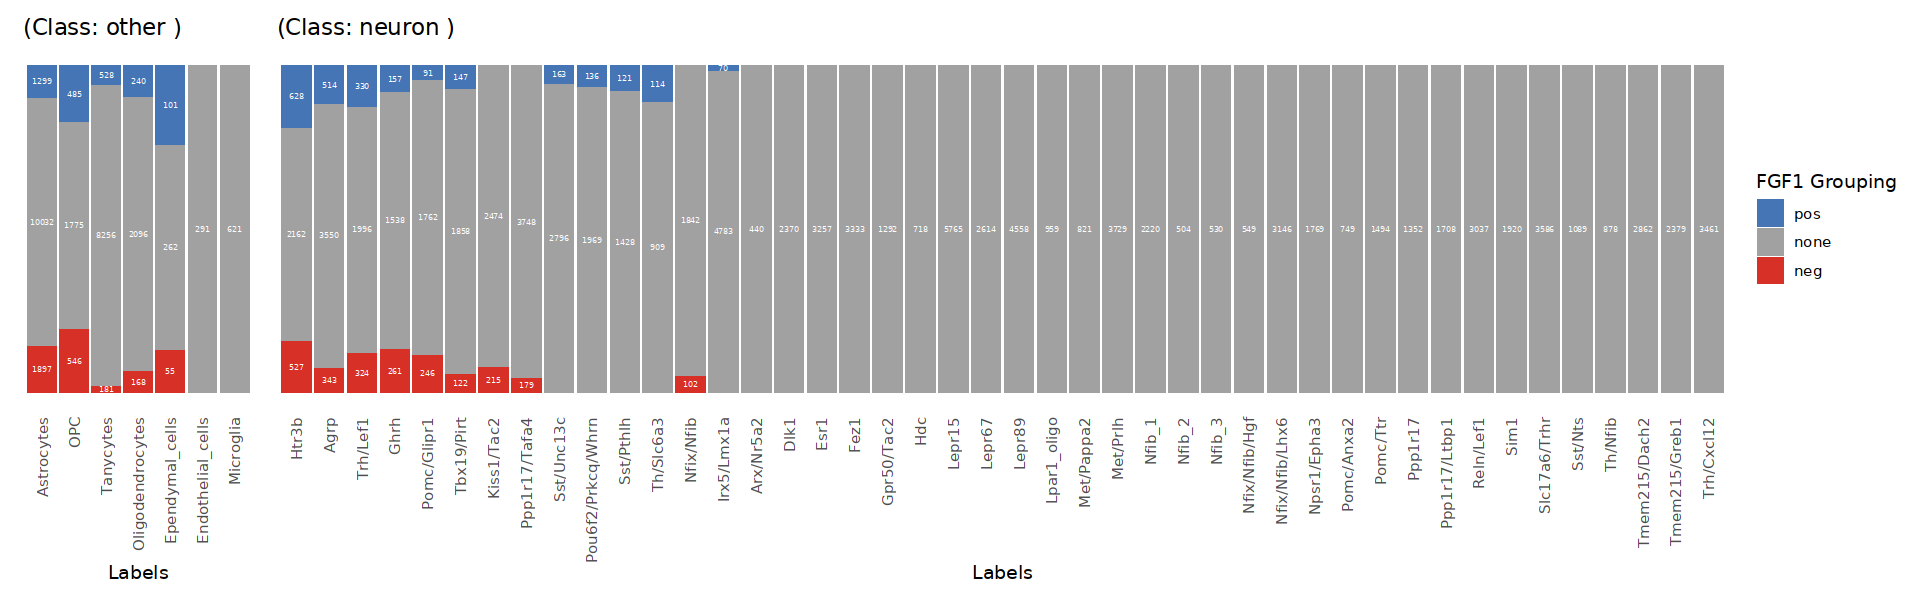

In [76]:
options(repr.plot.width=16, repr.plot.height=5)
# Create separate plots for each class
plots <- unique(final_summary_percent$class) %>%
  map(function(cl) {
    ggplot(final_summary_percent %>% filter(class == cl),
           aes(x = labels, y = percent, fill = fgf1_grouping)) +
      geom_bar(stat = "identity", position = "fill") +
      geom_text(aes(label = count), position = position_fill(vjust = 0.5), color = "white", size = 1.5) +
      scale_y_continuous(labels = scales::percent_format()) +
      scale_fill_manual(values = c('none' =  "#a1a1a1",
                                   'neg' = "#d73027",
                                   'pos' = "#4575b4")) +
      theme_minimal() + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) +
      labs(title = paste("(Class:", cl, ")"),
           x = "Labels",
           y = "Percentage",
           fill = "FGF1 Grouping") +
      theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + theme(
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) 
  })

# Calculate the widths based on the number of unique labels in each class
widths <- map_dbl(plots, ~length(unique(.$data$labels)))

# Combine the plots with adjusted widths
combined_plot <- wrap_plots(plots, widths = widths) + plot_layout(guides = "collect")

# Display the combined plot
combined_plot %>% ggsave('cell_sum_d5.pdf', plot = ., width = 16, height=5)
combined_plot

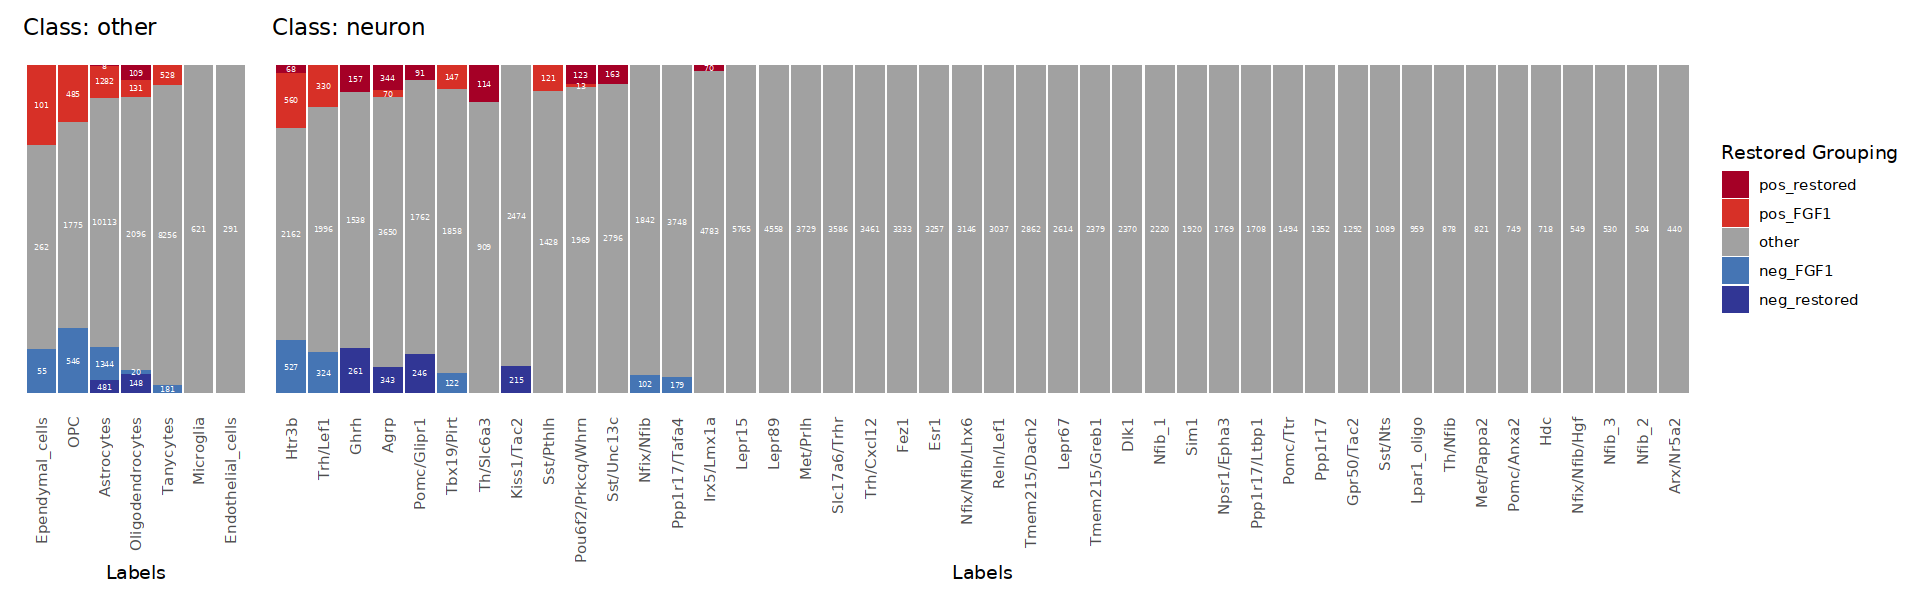

In [77]:
# beeswarm_results = qs::qread('beeswarm_da_results_d5_MAST.qs')
# Step 1: Modify restored_grouping
beeswarm_results <- beeswarm_results %>%
  mutate(restored_grouping = case_when(
    restored_grouping %in% c("pos_restored", "pos_FGF1", "neg_FGF1", "neg_restored") ~ restored_grouping,
    TRUE ~ "other"
  ))

# Step 2: Recalculate summaries and percentages
original_summary <- beeswarm_results %>%
  filter(!is.na(class)) %>%
  group_by(class, labels, restored_grouping) %>%
  summarise(count = n(), .groups = 'drop')

not_none_summary <- original_summary %>%
  filter(restored_grouping != 'other') %>%
  group_by(class, labels) %>%
  summarise(not_none_count = sum(count), .groups = 'drop')


# Step 2: Creating a summary for non-'none' categories
total_summary <- original_summary %>%
  group_by(class, labels) %>%
  summarise(total_count = sum(count), .groups = 'drop')

# Step 3: Joining the summaries
final_summary <- original_summary %>%
  left_join(not_none_summary, by = c("class", "labels")) %>%
  left_join(total_summary, by = c("class", "labels")) %>%
  mutate(not_none_count = replace_na(not_none_count, 0)) %>%
  arrange(desc(not_none_count), desc(total_count), labels) %>%
  mutate(labels = factor(labels, levels = unique(labels)))
         
final_summary_percent <- final_summary %>%
  group_by(class, labels) %>%
  mutate(total_count = sum(count)) %>%
  ungroup() %>%
  mutate(percent = count / total_count) %>%
  mutate(not_none_percent = not_none_count/ total_count) %>%
  mutate(restored_grouping = factor(restored_grouping, levels = c("pos_restored", "pos_FGF1", "other", "neg_FGF1", "neg_restored"))) %>%
  arrange(desc(not_none_percent), desc(count), labels)
  
saved_levels_2 = final_summary_percent %>% pull(labels) %>% unique

final_summary_percent = final_summary_percent %>%
    mutate(labels = factor(labels, levels=saved_levels_2))

# Step 3: Create plots for each class and combine them using patchwork
plots <- unique(final_summary_percent$class) %>%
  map(function(cl) {
    ggplot(final_summary_percent %>% filter(class == cl),
           aes(x = labels, y = percent, fill = restored_grouping)) +
      geom_bar(stat = "identity", position = "fill") +
      geom_text(aes(label = count), position = position_fill(vjust = 0.5), color = "white", size = 1.5) +
      scale_y_continuous(labels = scales::percent_format()) +
      scale_fill_manual(values = c(
        'other' =  "#a1a1a1",
        'neg_FGF1' = "#4575b4",
        'pos_FGF1' = "#d73027",
        'neg_restored' = "#313695",
        'pos_restored' = "#a50026"
      )) +
      theme_minimal() +
      theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
            axis.ticks = element_blank(),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.text.y = element_blank(),
            axis.title.y = element_blank()) +
      labs(title = paste("Class:", cl),
           x = "Labels",
           y = "Percentage",
           fill = "Restored Grouping")
  })

# Calculate the widths based on the number of unique labels in each class
widths <- map_dbl(plots, ~length(unique(.$data$labels)))

# Combine the plots with adjusted widths
combined_plot_fgf1 <- wrap_plots(plots, widths = widths) + plot_layout(guides = "collect")

# Display the combined plot
combined_plot_fgf1

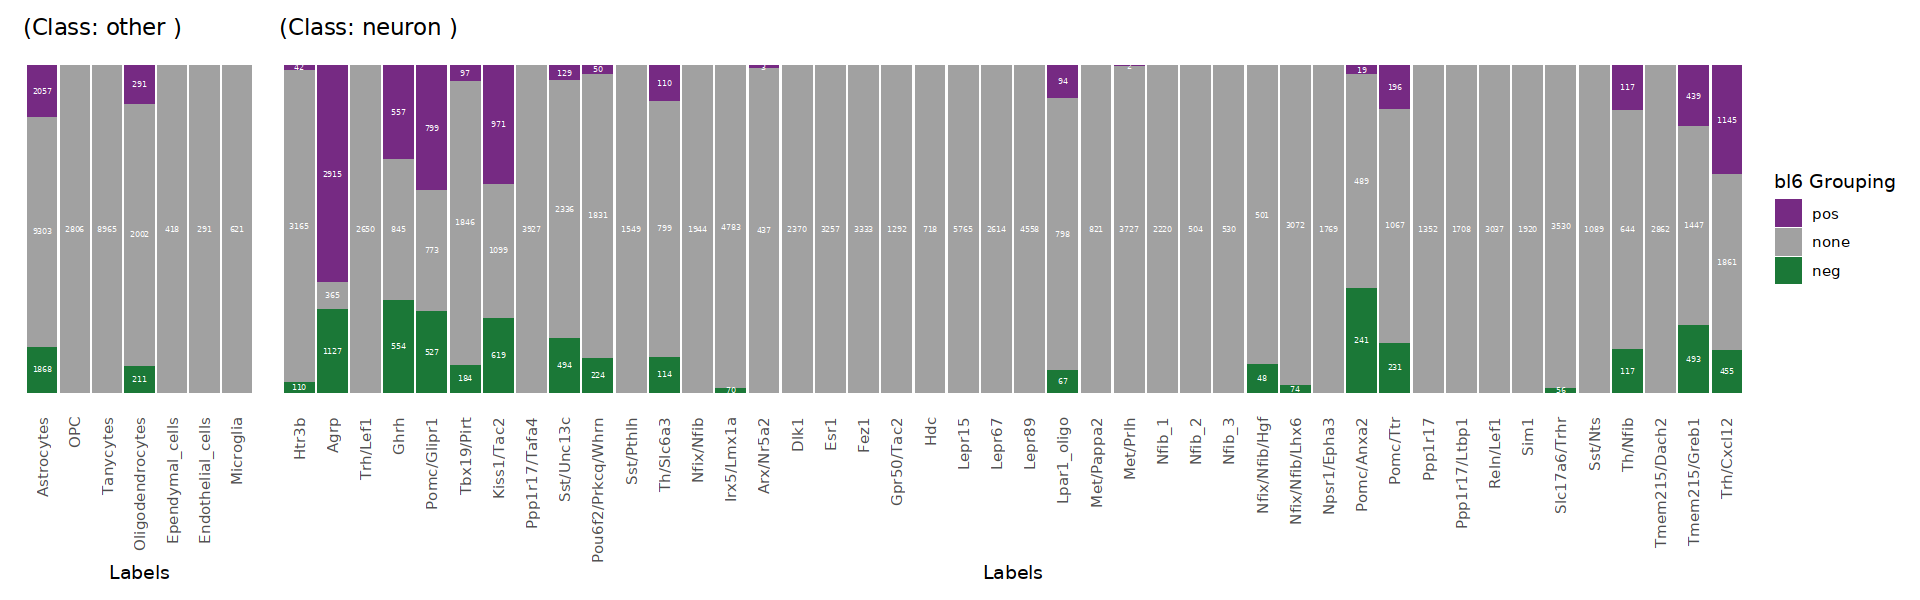

In [78]:
options(repr.plot.width=16, repr.plot.height=5)

# beeswarm_results = qs::qread('beeswarm_da_results_d5_MAST.qs')

# Step 1: Summarizing the original data including class
original_summary <- beeswarm_results %>%
  filter(!is.na(class)) %>%
  group_by(class, labels, polarity_bl6) %>%
  summarise(count = n(), .groups = 'drop')

# Step 2: Creating a summary for non-'none' categories
not_none_summary <- original_summary %>%
  filter(polarity_bl6 != 'none') %>%
  group_by(class, labels) %>%
  summarise(not_none_count = sum(count), .groups = 'drop')

# Step 2: Creating a summary for non-'none' categories
total_summary <- original_summary %>%
  group_by(class, labels) %>%
  summarise(total_count = sum(count), .groups = 'drop')

# Step 3: Joining the summaries
final_summary <- original_summary %>%
  left_join(not_none_summary, by = c("class", "labels")) %>%
  left_join(total_summary, by = c("class", "labels")) %>%
  mutate(not_none_count = replace_na(not_none_count, 0)) %>%
  arrange(desc(not_none_count), labels) %>%
  mutate(labels = factor(labels, levels = saved_levels))

# Step 4: Calculate percentages
final_summary_percent <- final_summary %>%
  group_by(class, labels) %>%
  mutate(total_count = sum(count)) %>%
  ungroup() %>%
  mutate(percent = count / total_count) %>%
  mutate(polarity_bl6 = factor(polarity_bl6, levels = c("pos", "none", "neg"))) %>%
mutate(class = factor(class, levels = c('neuron', 'other'))) %>%
arrange(desc(class))


# Create separate plots for each class
plots <- unique(final_summary_percent$class) %>%
  map(function(cl) {
    ggplot(final_summary_percent %>% filter(class == cl),
           aes(x = labels, y = percent, fill = polarity_bl6)) +
      geom_bar(stat = "identity", position = "fill") +
      geom_text(aes(label = count), position = position_fill(vjust = 0.5), color = "white", size = 1.5) +
      scale_y_continuous(labels = scales::percent_format()) +
      scale_fill_manual(values = c('none' =  "#a1a1a1",
                                   'neg' = "#1b7837",
                                   'pos' = "#762a83")) +
      theme_minimal() + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) +
      labs(title = paste("(Class:", cl, ")"),
           x = "Labels",
           y = "Percentage",
           fill = "bl6 Grouping") +
      theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + theme(
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) 
  })

# Calculate the widths based on the number of unique labels in each class
widths <- map_dbl(plots, ~length(unique(.$data$labels)))

# Combine the plots with adjusted widths
combined_plot_bl6 <- wrap_plots(plots, widths = widths) + plot_layout(guides = "collect") +
  plot_layout(guides = 'collect')

# Display the combined plot
combined_plot %>% ggsave('cell_sum_d5.pdf', plot = ., width = 16, height=5)
combined_plot_bl6

In [79]:
options(repr.plot.width=16, repr.plot.height=10)
combined_plots = (combined_plot_fgf1 & 
  theme(axis.text.x = element_blank(),
        axis.ticks.x = element_blank(), 
        axis.title.x = element_blank())) / (combined_plot_bl6 & 
  theme(plot.title = element_blank()))
combined_plots = combined_plots + plot_layout(guides = 'collect')



combined_plots %>% ggsave('cell_sum_d5_MAST.pdf', plot = ., width = 16, height=10)

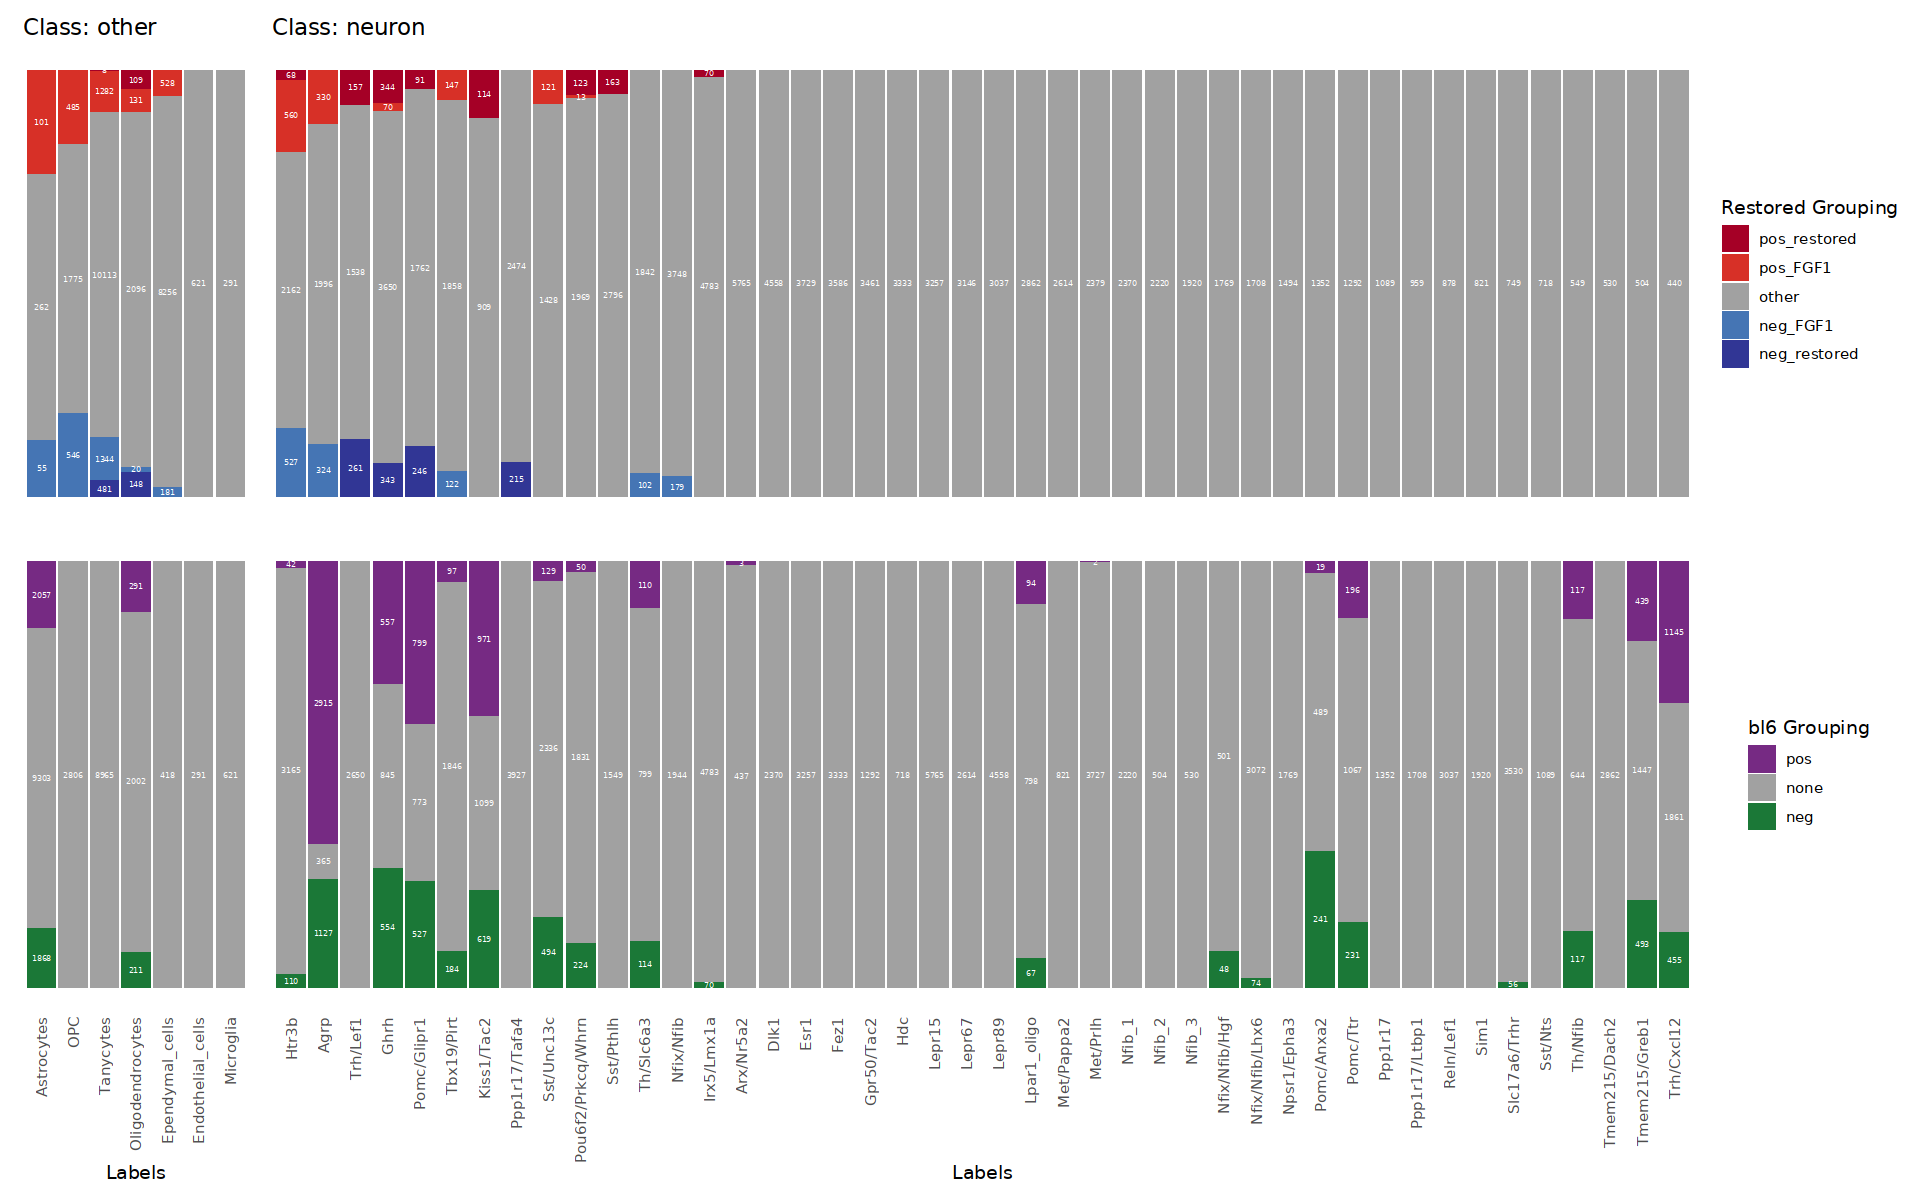

In [80]:
combined_plots

In [81]:
options(repr.plot.width=16, repr.plot.height=5)

# beeswarm_results = qs::qread('beeswarm_da_results_d5_MAST.qs')

# Step 1: Summarizing the original data including class
original_summary <- beeswarm_results %>%
  filter(!is.na(class)) %>%
  group_by(class, labels, polarity_bl6) %>%
  summarise(count = n(), .groups = 'drop')

# Step 2: Creating a summary for non-'none' categories
not_none_summary <- original_summary %>%
  filter(polarity_bl6 != 'none') %>%
  group_by(class, labels) %>%
  summarise(not_none_count = sum(count), .groups = 'drop')

# Step 2: Creating a summary for non-'none' categories
total_summary <- original_summary %>%
  group_by(class, labels) %>%
  summarise(total_count = sum(count), .groups = 'drop')

# Step 3: Joining the summaries
final_summary <- original_summary %>%
  left_join(not_none_summary, by = c("class", "labels")) %>%
  left_join(total_summary, by = c("class", "labels")) %>%
  mutate(not_none_count = replace_na(not_none_count, 0)) %>%
  arrange(desc(not_none_count), labels) %>%
  mutate(labels = factor(labels, levels = saved_levels))

# Step 4: Calculate percentages
final_summary_percent <- final_summary %>%
  group_by(class, labels) %>%
  mutate(total_count = sum(count)) %>%
  ungroup() %>%
  mutate(percent = count / total_count) %>%
  mutate(polarity_bl6 = factor(polarity_bl6, levels = c("pos", "none", "neg"))) %>%
mutate(class = factor(class, levels = c('neuron', 'other'))) %>%
arrange(desc(class))


# Create separate plots for each class
plots <- unique(final_summary_percent$class) %>%
  map(function(cl) {
    ggplot(final_summary_percent %>% filter(class == cl),
           aes(x = labels, y = percent, fill = polarity_bl6)) +
      geom_bar(stat = "identity", position = "fill") +
      geom_text(aes(label = count), position = position_fill(vjust = 0.5), color = "white", size = 1.5) +
      scale_y_continuous(labels = scales::percent_format()) +
      scale_fill_manual(values = c('none' =  "#a1a1a1",
                                   'neg' = "#1b7837",
                                   'pos' = "#762a83")) +
      theme_minimal() + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) +
      labs(title = paste("(Class:", cl, ")"),
           x = "Labels",
           y = "Percentage",
           fill = "bl6 Grouping") +
      theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + theme(
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) 
  })

# Calculate the widths based on the number of unique labels in each class
widths <- map_dbl(plots, ~length(unique(.$data$labels)))

# Combine the plots with adjusted widths
combined_plot_bl6 <- wrap_plots(plots, widths = widths) + plot_layout(guides = "collect") +
  plot_layout(guides = 'collect')

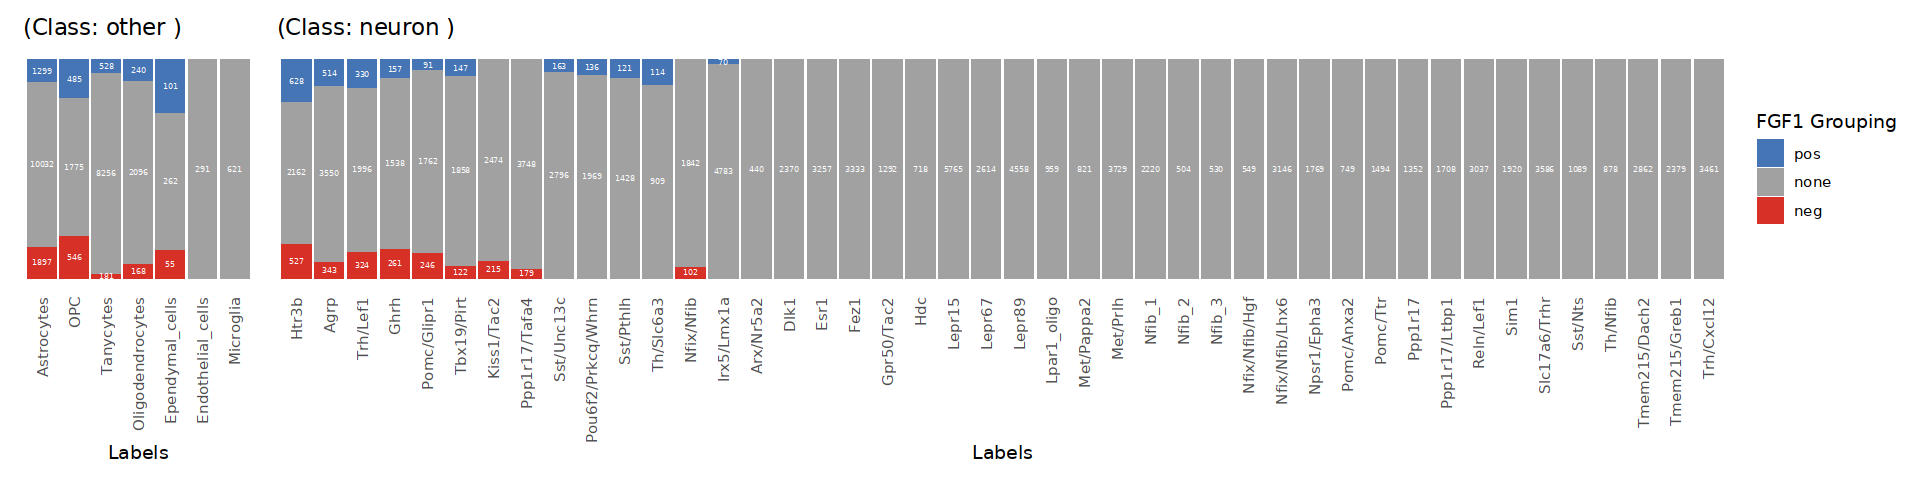

In [82]:
options(repr.plot.width=16, repr.plot.height=4)
combined_plot

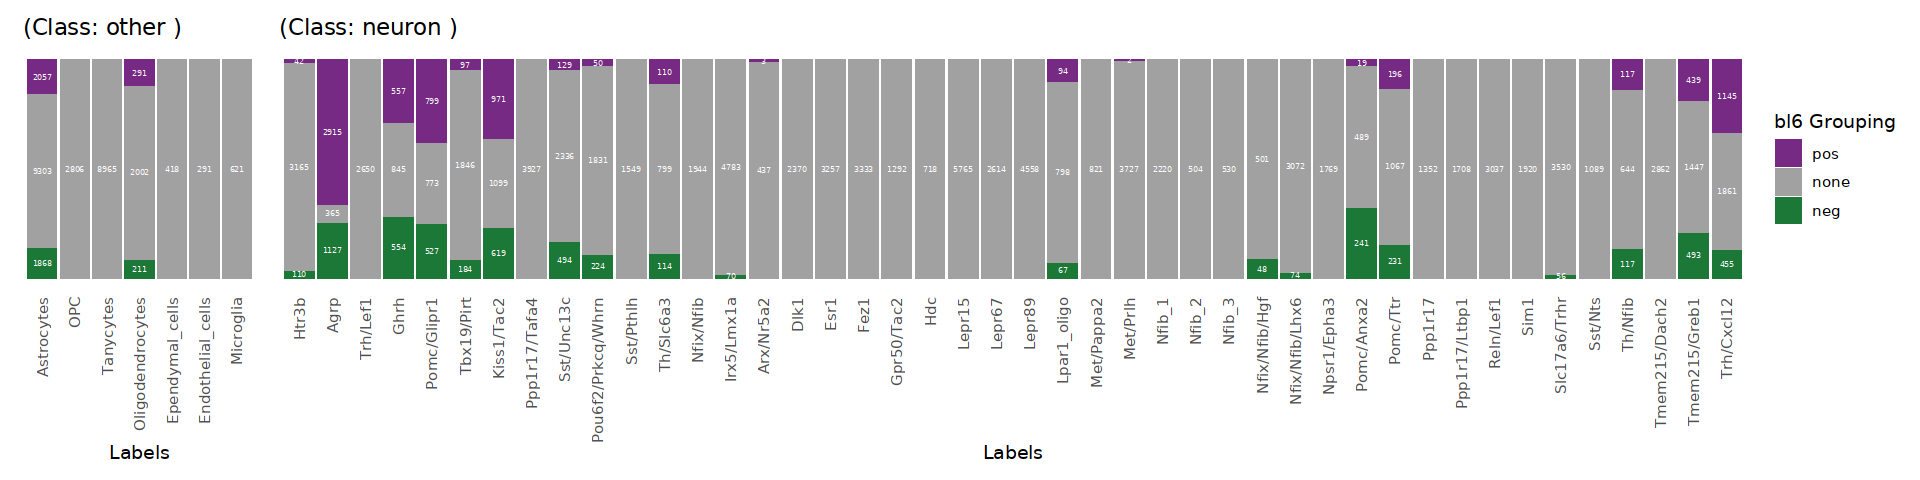

In [83]:
options(repr.plot.width=16, repr.plot.height=4)
combined_plot_bl6

In [84]:
options(repr.plot.width=16, repr.plot.height=6)
combined_plots_no_restore = (combined_plot & 
  theme(axis.text.x = element_blank(),
        axis.ticks.x = element_blank(), 
        axis.title.x = element_blank())) / (combined_plot_bl6 & 
  theme(plot.title = element_blank()))
combined_plots = combined_plots + plot_layout(guides = 'collect')



combined_plots_no_restore %>% ggsave('cell_sum_d5_MAST_no_restore.pdf', plot = ., width = 16, height=6)

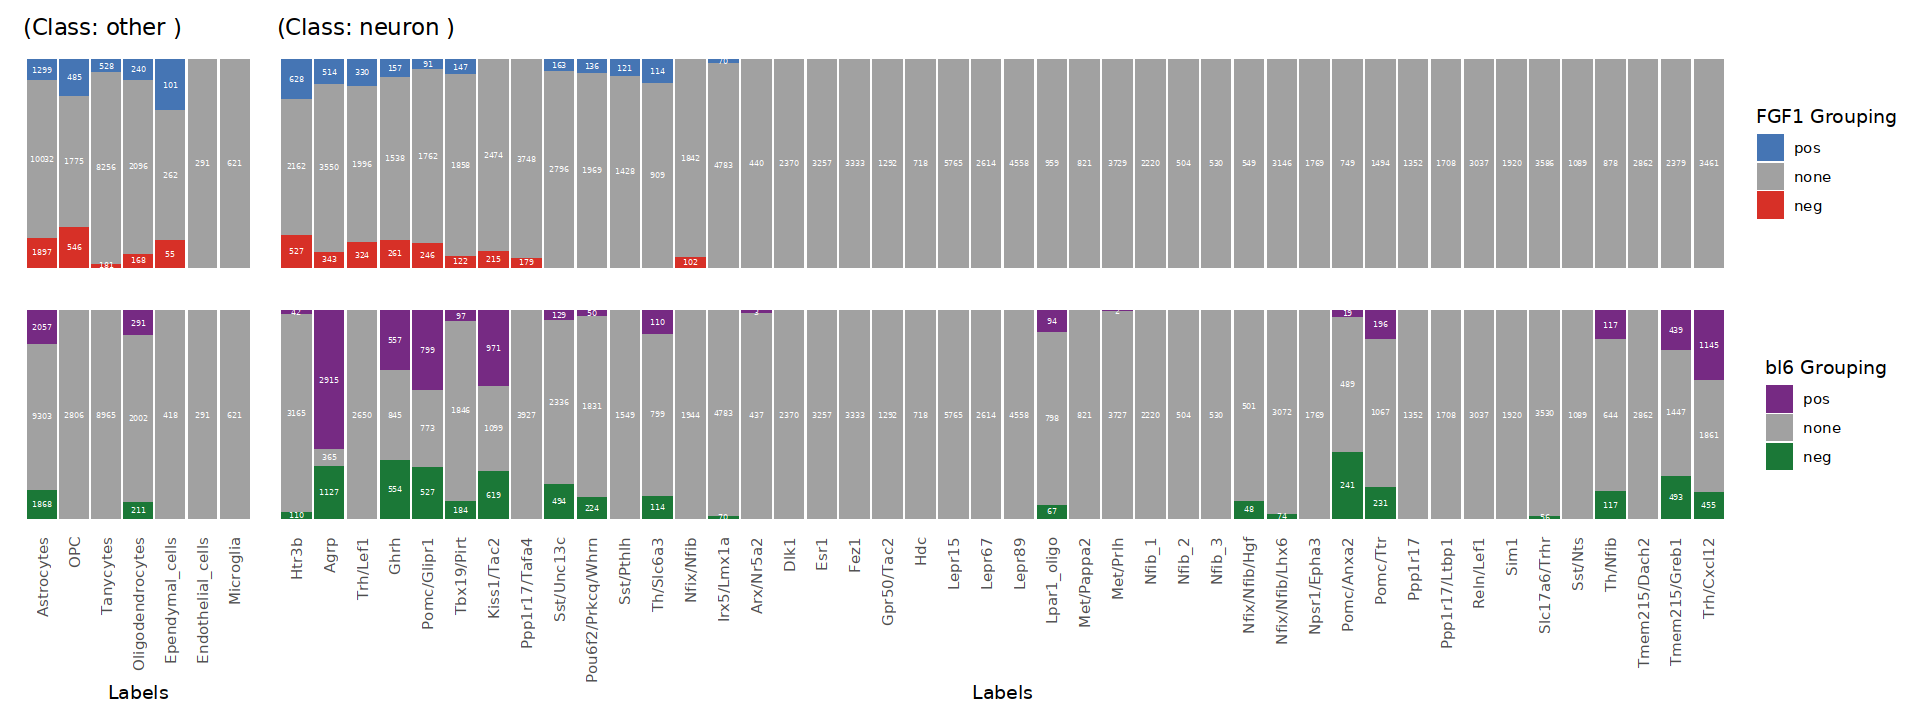

In [85]:
combined_plots_no_restore

In [86]:
final_summary_percent_d5 = final_summary_percent 
final_summary_percent_d5 %>% write_xlsx('cell_DA_summary_Day5.xlsx')

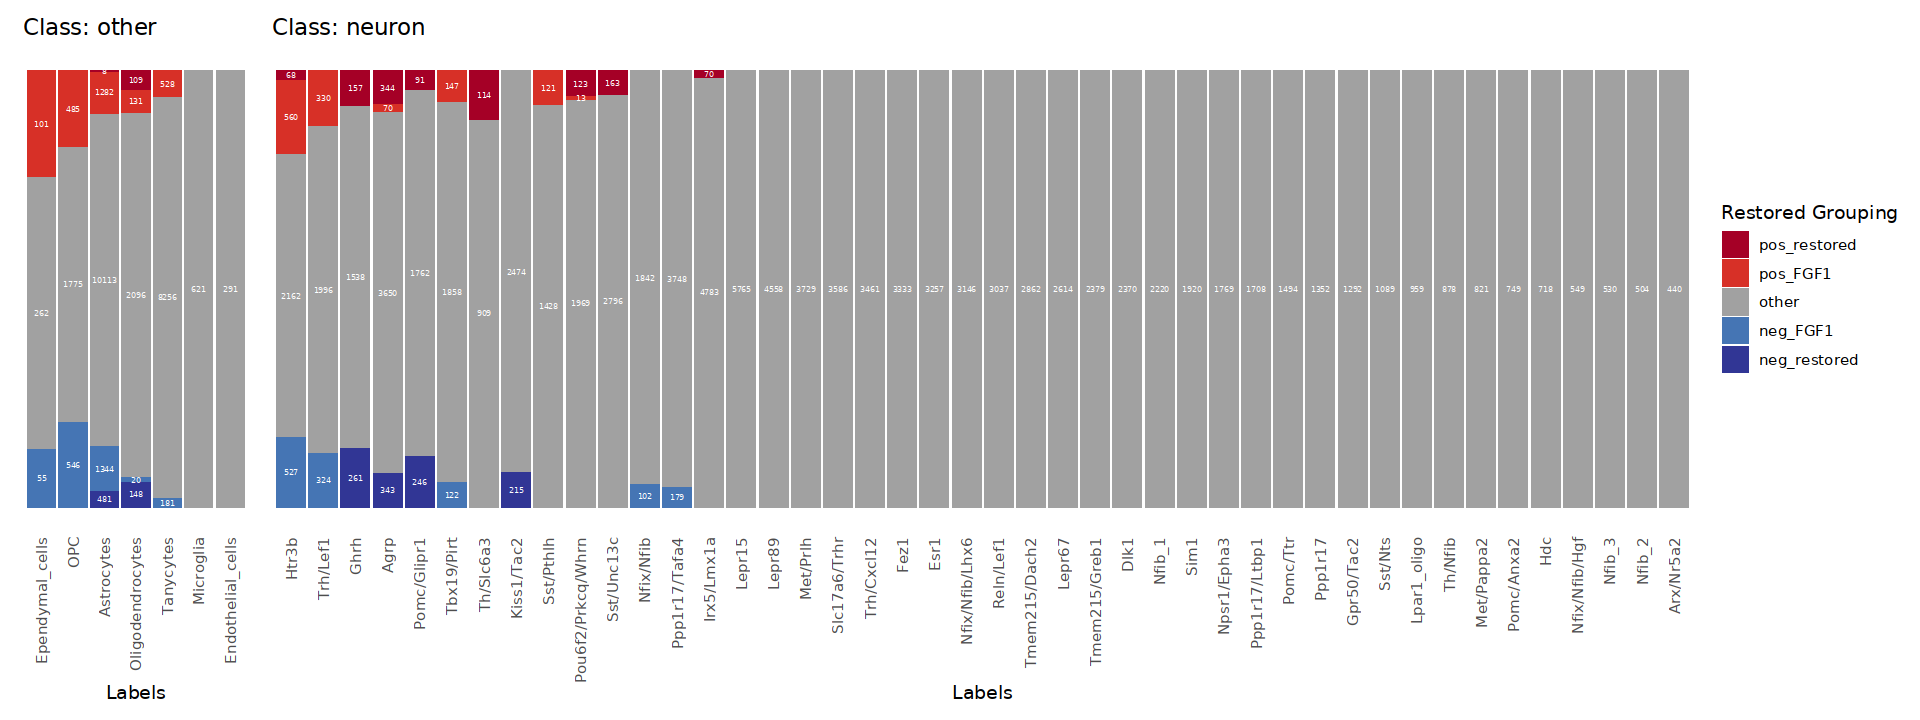

In [87]:
# Step 1: Modify restored_grouping
beeswarm_results <- beeswarm_results %>%
  mutate(restored_grouping = case_when(
    restored_grouping %in% c("pos_restored", "pos_FGF1", "neg_FGF1", "neg_restored") ~ restored_grouping,
    TRUE ~ "other"
  ))

# Step 2: Recalculate summaries and percentages
original_summary <- beeswarm_results %>%
  filter(!is.na(class)) %>%
  group_by(class, labels, restored_grouping) %>%
  summarise(count = n(), .groups = 'drop')

not_none_summary <- original_summary %>%
  filter(restored_grouping != 'other') %>%
  group_by(class, labels) %>%
  summarise(not_none_count = sum(count), .groups = 'drop')


# Step 2: Creating a summary for non-'none' categories
total_summary <- original_summary %>%
  group_by(class, labels) %>%
  summarise(total_count = sum(count), .groups = 'drop')

# Step 3: Joining the summaries
final_summary <- original_summary %>%
  left_join(not_none_summary, by = c("class", "labels")) %>%
  left_join(total_summary, by = c("class", "labels")) %>%
  mutate(not_none_count = replace_na(not_none_count, 0)) %>%
  arrange(desc(not_none_count), desc(total_count), labels) %>%
  mutate(labels = factor(labels, levels = unique(labels)))
         
final_summary_percent <- final_summary %>%
  group_by(class, labels) %>%
  mutate(total_count = sum(count)) %>%
  ungroup() %>%
  mutate(percent = count / total_count) %>%
  mutate(not_none_percent = not_none_count/ total_count) %>%
  mutate(restored_grouping = factor(restored_grouping, levels = c("pos_restored", "pos_FGF1", "other", "neg_FGF1", "neg_restored"))) %>%
  arrange(desc(not_none_percent), desc(count), labels) %>%
mutate(class = factor(class, levels = c('neuron', 'other'))) %>%
arrange(desc(class))
  
saved_levels = final_summary_percent %>% pull(labels) %>% unique

final_summary_percent = final_summary_percent %>%
    mutate(labels = factor(labels, levels=saved_levels))

# Step 3: Create plots for each class and combine them using patchwork
plots <- unique(final_summary_percent$class) %>%
  map(function(cl) {
    ggplot(final_summary_percent %>% filter(class == cl),
           aes(x = labels, y = percent, fill = restored_grouping)) +
      geom_bar(stat = "identity", position = "fill") +
      geom_text(aes(label = count), position = position_fill(vjust = 0.5), color = "white", size = 1.5) +
      scale_y_continuous(labels = scales::percent_format()) +
      scale_fill_manual(values = c(
        'other' =  "#a1a1a1",
        'neg_FGF1' = "#4575b4",
        'pos_FGF1' = "#d73027",
        'neg_restored' = "#313695",
        'pos_restored' = "#a50026"
      )) +
      theme_minimal() +
      theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
            axis.ticks = element_blank(),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.text.y = element_blank(),
            axis.title.y = element_blank()) +
      labs(title = paste("Class:", cl),
           x = "Labels",
           y = "Percentage",
           fill = "Restored Grouping")
  })

# Calculate the widths based on the number of unique labels in each class
widths <- map_dbl(plots, ~length(unique(.$data$labels)))

# Combine the plots with adjusted widths
combined_plot_fgf1 <- wrap_plots(plots, widths = widths) + plot_layout(guides = "collect")

# Display the combined plot
combined_plot_fgf1

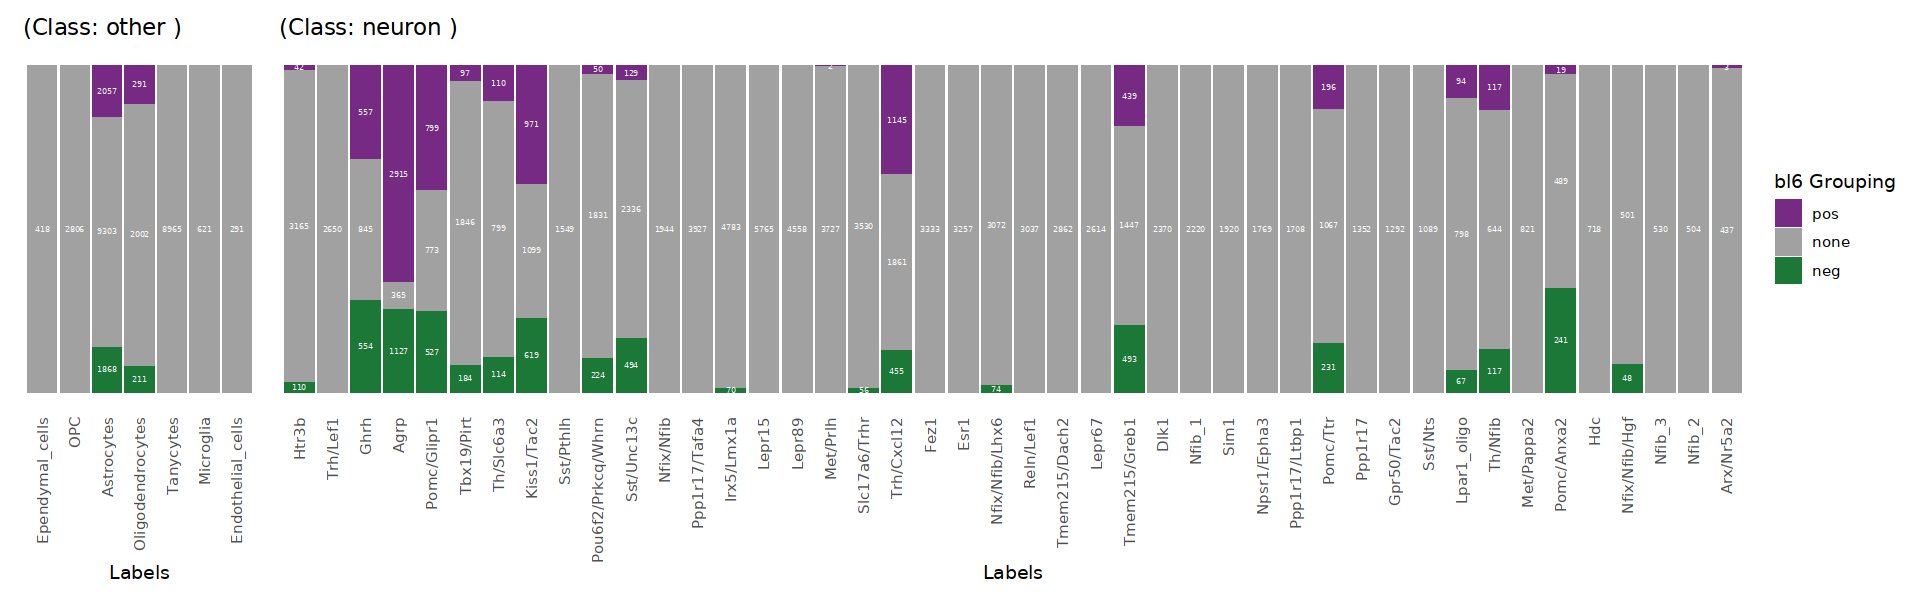

In [88]:
options(repr.plot.width=16, repr.plot.height=5)


# Step 1: Summarizing the original data including class
original_summary <- beeswarm_results %>%
  filter(!is.na(class)) %>%
  group_by(class, labels, polarity_bl6) %>%
  summarise(count = n(), .groups = 'drop')

# Step 2: Creating a summary for non-'none' categories
not_none_summary <- original_summary %>%
  filter(polarity_bl6 != 'none') %>%
  group_by(class, labels) %>%
  summarise(not_none_count = sum(count), .groups = 'drop')

# Step 2: Creating a summary for non-'none' categories
total_summary <- original_summary %>%
  group_by(class, labels) %>%
  summarise(total_count = sum(count), .groups = 'drop')

# Step 3: Joining the summaries
final_summary <- original_summary %>%
  left_join(not_none_summary, by = c("class", "labels")) %>%
  left_join(total_summary, by = c("class", "labels")) %>%
  mutate(not_none_count = replace_na(not_none_count, 0)) %>%
  arrange(desc(not_none_count), labels) %>%
  mutate(labels = factor(labels, levels = saved_levels))

# Step 4: Calculate percentages
final_summary_percent <- final_summary %>%
  group_by(class, labels) %>%
  mutate(total_count = sum(count)) %>%
  ungroup() %>%
  mutate(percent = count / total_count) %>%
  mutate(polarity_bl6 = factor(polarity_bl6, levels = c("pos", "none", "neg"))) %>%
mutate(class = factor(class, levels = c('neuron', 'other'))) %>%
arrange(desc(class))


# Create separate plots for each class
plots <- unique(final_summary_percent$class) %>%
  map(function(cl) {
    ggplot(final_summary_percent %>% filter(class == cl),
           aes(x = labels, y = percent, fill = polarity_bl6)) +
      geom_bar(stat = "identity", position = "fill") +
      geom_text(aes(label = count), position = position_fill(vjust = 0.5), color = "white", size = 1.5) +
      scale_y_continuous(labels = scales::percent_format()) +
      scale_fill_manual(values = c('none' =  "#a1a1a1",
                                   'neg' = "#1b7837",
                                   'pos' = "#762a83")) +
      theme_minimal() + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) +
      labs(title = paste("(Class:", cl, ")"),
           x = "Labels",
           y = "Percentage",
           fill = "bl6 Grouping") +
      theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + theme(
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) 
  })

# Calculate the widths based on the number of unique labels in each class
widths <- map_dbl(plots, ~length(unique(.$data$labels)))

# Combine the plots with adjusted widths
combined_plot_bl6 <- wrap_plots(plots, widths = widths) + plot_layout(guides = "collect") +
  plot_layout(guides = 'collect')

# Display the combined plot
combined_plot %>% ggsave('cell_sum_d5.pdf', plot = ., width = 16, height=5)
combined_plot_bl6

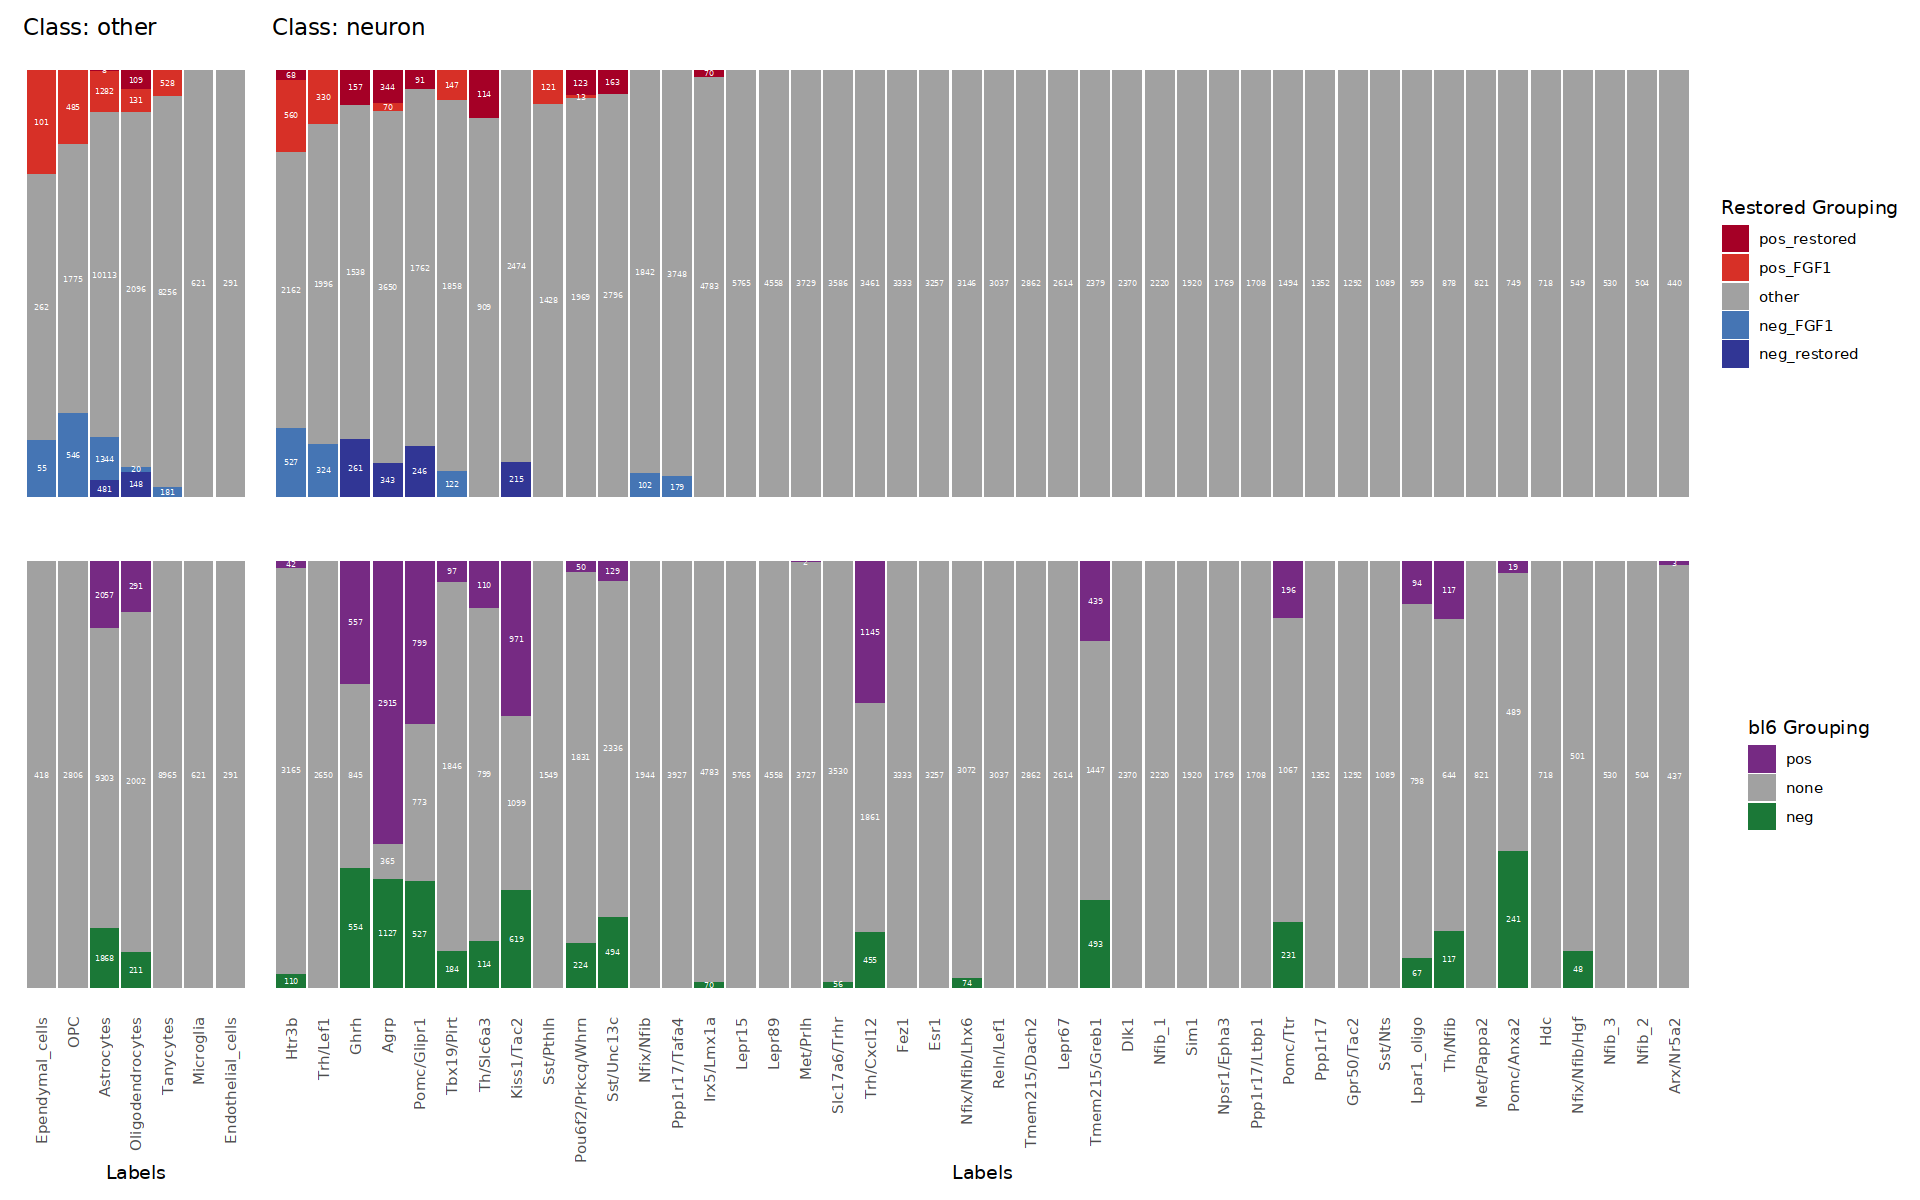

In [89]:
options(repr.plot.width=16, repr.plot.height=10)
combined_plots = (combined_plot_fgf1 & 
  theme(axis.text.x = element_blank(),
        axis.ticks.x = element_blank(), 
        axis.title.x = element_blank())) / (combined_plot_bl6 & 
  theme(plot.title = element_blank()))
combined_plots = combined_plots + plot_layout(guides = 'collect')



combined_plots %>% ggsave('cell_sum_d14_MAST.pdf', plot = ., width = 16, height=10)
combined_plots

In [90]:
final_summary_percent_d14 = final_summary_percent 
final_summary_percent_d14 %>% write_xlsx('cell_DA_summary_Day14.xlsx')

In [91]:
final_summary_percent_d5 - final_summary_percent_d14

Warning message in Ops.factor(left, right):
“‘-’ not meaningful for factors”
Warning message in Ops.factor(left, right):
“‘-’ not meaningful for factors”
Warning message in Ops.factor(left, right):
“‘-’ not meaningful for factors”


class,labels,polarity_bl6,count,not_none_count,total_count,percent
<lgl>,<lgl>,<lgl>,<int>,<int>,<int>,<dbl>
NA,NA,NA,0,0,0,0
NA,NA,NA,0,0,0,0
NA,NA,NA,0,0,0,0
NA,NA,NA,0,0,0,0
NA,NA,NA,0,0,0,0
NA,NA,NA,0,0,0,0
NA,NA,NA,0,0,0,0
NA,NA,NA,0,0,0,0
NA,NA,NA,0,0,0,0


In [92]:
final_summary_percent_d5 %>% print

# A tibble: 91 × 7
   class labels            polarity_bl6 count not_none_count total_count percent
   <fct> <fct>             <fct>        <int>          <int>       <int>   <dbl>
 1 other Astrocytes        neg           1868           3925       13228  0.141 
 2 other Astrocytes        none          9303           3925       13228  0.703 
 3 other Astrocytes        pos           2057           3925       13228  0.156 
 4 other Oligodendrocytes  neg            211            502        2504  0.0843
 5 other Oligodendrocytes  none          2002            502        2504  0.800 
 6 other Oligodendrocytes  pos            291            502        2504  0.116 
 7 other Endothelial_cells none           291              0         291  1     
 8 other Ependymal_cells   none           418              0         418  1     
 9 other Microglia         none           621              0         621  1     
10 other OPC               none          2806              0        2806  1     
# ℹ 81 mo

In [93]:
final_summary_percent_d14 %>% print

# A tibble: 91 × 7
   class labels            polarity_bl6 count not_none_count total_count percent
   <fct> <fct>             <fct>        <int>          <int>       <int>   <dbl>
 1 other Astrocytes        neg           1868           3925       13228  0.141 
 2 other Astrocytes        none          9303           3925       13228  0.703 
 3 other Astrocytes        pos           2057           3925       13228  0.156 
 4 other Oligodendrocytes  neg            211            502        2504  0.0843
 5 other Oligodendrocytes  none          2002            502        2504  0.800 
 6 other Oligodendrocytes  pos            291            502        2504  0.116 
 7 other Endothelial_cells none           291              0         291  1     
 8 other Ependymal_cells   none           418              0         418  1     
 9 other Microglia         none           621              0         621  1     
10 other OPC               none          2806              0        2806  1     
# ℹ 81 mo

In [94]:
combined_data <- full_join(final_summary_percent_d5, final_summary_percent_d14, 
                           by = c("class", "labels", "polarity_bl6"), 
                           suffix = c("_d5", "_d14"))

# Step 2: Calculating the difference
combined_data <- combined_data %>%
  mutate(difference = replace_na(percent_d14, 0) - replace_na(percent_d5, 0))

# Step 3: Select and arrange columns if necessary
result_tibble <- combined_data %>%
  select(class, labels, polarity_bl6, percent_d5, percent_d14, difference)

result_tibble %>% filter(polarity_bl6 != 'none')

class,labels,polarity_bl6,percent_d5,percent_d14,difference
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
other,Astrocytes,neg,0.1412156033,0.1412156033,0
other,Astrocytes,pos,0.1555034775,0.1555034775,0
other,Oligodendrocytes,neg,0.0842651757,0.0842651757,0
other,Oligodendrocytes,pos,0.1162140575,0.1162140575,0
neuron,Agrp,neg,0.2557295212,0.2557295212,0
neuron,Agrp,pos,0.6614476968,0.6614476968,0
neuron,Trh/Cxcl12,neg,0.1314648945,0.1314648945,0
neuron,Trh/Cxcl12,pos,0.3308292401,0.3308292401,0
neuron,Kiss1/Tac2,neg,0.2301970993,0.2301970993,0


In [95]:
result_tibble %>% write_xlsx('cell_DA_summary_diff_bl6.xlsx')